!pip install --upgrade --force-reinstall plotly

# 1.0 Setup

In [0]:
#import importlib
#plotly_spec = importlib.util.find_spec('plotly')
#print(plotly_spec)
#if plotly_spec is None:
#    print('Installing plotly...')
!pip install --upgrade --force-reinstall plotly
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3
!pip install xlrd

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
  Using cached https://files.pythonhosted.org/packages/49/df/50aa1999ab9bde74656c2919d9c0c085fd2b3775fd3eca826012bef76d8c/requests-2.18.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/dc/83/15f7833b70d3e067ca91467ca245bae0f6fe56ddc7451aa0dc5606b120f2/pytz-2018.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/bb/a24838832ba35baf52f32ab1a49b906b5f82fb7c76b2f6a7e35e140bac30/decorator-4.3.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/67/4b/141a581104b1f6397bfa78ac9d43d8ad29a7ca43ea90a2d863fe3056e86a/six-1.11.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/da/27/9a654d2b6cc1eaa517d1c5a4405166c7f6d72f04f6e7eea41855fe808a46/nbformat-4.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/63/cb/6965947c13a94236f6d4b8223e21beb4d576dc72e8130bd7880f600839b8/urllib3-1.22-py2.

  Running setup.py bdist_wheel for pyproj ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/89/77/ec/a537585d1022dafde0317dd19d33c4a30d4ee61e19f25ebd8e
  Running setup.py bdist_wheel for click-plugins ... - done
  Stored in directory: /content/.cache/pip/wheels/bc/86/aa/7680e54728998edc1e966a20249b920e582012ed6bdd3815c4
  Running setup.py bdist_wheel for munch ... - done
  Stored in directory: /content/.cache/pip/wheels/71/0e/ac/a0eae94b87bb4e8ff939cc2cd5f9f9926881aa46681e5137b8
Successfully built pyproj click-plugins munch
Looki

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
from IPython.display import display, HTML
init_notebook_mode(connected=True)
import os
from os import listdir

In [0]:
!ls -la dswg/data

ls: cannot access 'dswg/data': No such file or directory


In [0]:
!pwd

/content


In [0]:
cwd = os.getcwd()
if cwd == '/home/jovyan':  # We are in Jupyter Docker
    datadir = '/home/jovyan/work/dswg/data'
elif cwd == '/content':    # We are in Google Colab
    datadir = '/content/dswg/data'
print(datadir,':')
if os.path.exists(datadir):
  print(listdir(datadir))
else:
  print("DOESN'T EXIST")

/content/dswg/data :
DOESN'T EXIST


In [0]:
if not os.path.exists(datadir + '/patients.csv'): 
    # Checkout the data from Github
    !git clone https://github.com/stevejohnson2001/dswg
    !mkdir /content/dswg/data/temp

Cloning into 'dswg'...
remote: Counting objects: 72, done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 72 (delta 30), reused 32 (delta 13), pack-reused 0
Unpacking objects: 100% (72/72), done.


## 1.1 Read in the data

In [0]:
# Read in the data
dd = {}

dd['patients'] = {'pat_id':     {'type': np.str, 'required':True, 'primarykey_col':0},
                  'birth_date': {'type': np.datetime64, 'required':True},
                  'death_date': {'type': np.datetime64}, 
                  'ssn':        {'type': np.str},
                  'drivers':    {'type': np.str},
                  'passport':   {'type': np.str},
                  'prefix':     {'type': np.str},
                  'first':      {'type': np.str, 'required':True},
                  'last':       {'type': np.str, 'required':True},
                  'suffix':     {'type': np.str},
                  'maiden':     {'type': np.str},
                  'marital':    {'type': np.str},
                  'race':       {'type': np.str},
                  'ethnicity':  {'type': np.str},
                  'gender':     {'type': np.str, 'required':True},
                  'birthplace': {'type': np.str},
                  'address':    {'type': np.str, 'required':True}
                  }
dd['encounters'] = {'enc_id':                 {'type': np.str, 'required':True, 'primarykey_col':0},
                    'enc_date':               {'type': np.datetime64, 'required':True},
                    'enc_pat_id':             {'type': np.str, 'required':True},
                    'enc_code':               {'type': np.str, 'required':True},
                    'enc_description':        {'type': np.str, 'required':True},
                    'enc_reason_code':        {'type': np.str},
                    'enc_reason_description': {'type': np.str}
                   }
dd['observations'] = {'obs_date':        {'type': np.datetime64, 'required':True},
                      'obs_pat_id':      {'type': np.str, 'required':True},
                      'obs_enc_id':      {'type': np.str, 'required':True},
                      'obs_code':        {'type': np.str, 'required':True},
                      'obs_description': {'type': np.str, 'required':True},
                      'obs_value':       {'type': np.str},
                      'obs_units':       {'type': np.str}
                     }
dd['medications'] = {'med_start_date':         {'type': np.datetime64, 'required':True},
                     'med_stop_date':          {'type': np.str, 'required':False},
                     'med_pat_id':             {'type': np.str, 'required':True},
                     'med_enc_id':             {'type': np.str, 'required':True},
                     'med_code':               {'type': np.str, 'required':True},
                     'med_description':        {'type': np.str, 'required':True},
                     'med_reason_code':        {'type': np.str},
                     'med_reason_description': {'type': np.str}
                     }


data = {}
for f in dd:
    m = dd[f]
    col_names = list(m.keys())
    data_types = {k: (v['type'] if v['type'] != np.datetime64 else np.str) for (k,v) in m.items()}
    date_cols = [k for k,v in m.items() if v['type'] == np.datetime64]
    key_cols = [v['primarykey_col'] for k,v in m.items() if 'primarykey_col' in v]
    if len(key_cols) == 0:
        key_cols = None
    print('{}:'.format(f))
    print('  keys:  {}'.format(key_cols))
    print('  types: {}'.format(data_types))
    print('  cols:  {}'.format(col_names))
    print('  dates: {}'.format(date_cols))
    data[f] = pd.read_csv(datadir + '/{}.csv'.format(f), index_col=key_cols, dtype=data_types, header=0, parse_dates=date_cols, names=col_names)
    display(data[f].head(5))
    print(data[f].dtypes)

patients:
  keys:  [0]
  types: {'pat_id': <class 'str'>, 'birth_date': <class 'str'>, 'death_date': <class 'str'>, 'ssn': <class 'str'>, 'drivers': <class 'str'>, 'passport': <class 'str'>, 'prefix': <class 'str'>, 'first': <class 'str'>, 'last': <class 'str'>, 'suffix': <class 'str'>, 'maiden': <class 'str'>, 'marital': <class 'str'>, 'race': <class 'str'>, 'ethnicity': <class 'str'>, 'gender': <class 'str'>, 'birthplace': <class 'str'>, 'address': <class 'str'>}
  cols:  ['pat_id', 'birth_date', 'death_date', 'ssn', 'drivers', 'passport', 'prefix', 'first', 'last', 'suffix', 'maiden', 'marital', 'race', 'ethnicity', 'gender', 'birthplace', 'address']
  dates: ['birth_date', 'death_date']


,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,maiden,marital,race,ethnicity,gender,birthplace,address
pat_id,,,,,,,,,,,,,,,,
a5bf8162-2080-41b2-a30b-1fdbc1e8a283,2014-12-12,NaT,999-84-5231,NaN,NaN,NaN,Ashley34,Becker968,NaN,NaN,NaN,white,german,F,Huntership,775 Prosacco Ville Minneapolis Minnesota 55401 US
03e552de-c720-42af-9995-79649f3f05e4,2004-07-08,NaT,999-48-8276,NaN,NaN,NaN,Lili474,Johns824,NaN,NaN,NaN,white,german,F,Bloomington,303 Mertz Esplanade Edina Minnesota 55343 US
827002da-feb8-4848-9ef8-a203f5c50f83,2004-03-24,NaT,999-22-9579,NaN,NaN,NaN,Noble66,Hintz995,NaN,NaN,NaN,white,french,M,Dell Groveship,740 Schmidt Heights Apt 24 Apple Valley Minnes...
d7f8622f-0fe9-43e3-97f7-297239cf2bd8,1959-12-03,2005-11-25,999-79-5940,S99947417,X40810024X,Mr.,Randolph418,Runolfsson901,NaN,NaN,M,white,greek,M,St. Cloud,577 Prohaska Drive Unit 73 Lino Lakes Minnesot...
a36ab7ef-2027-447b-b106-1cfb20fdcb9e,2008-12-23,NaT,999-25-8022,NaN,NaN,NaN,Delana41,Reynolds644,NaN,NaN,NaN,white,irish,F,Eagan,216 Stiedemann Manor Minneapolis Minnesota 554...


birth_date    datetime64[ns]
death_date    datetime64[ns]
ssn                   object
drivers               object
passport              object
prefix                object
first                 object
last                  object
suffix                object
maiden                object
marital               object
race                  object
ethnicity             object
gender                object
birthplace            object
address               object
dtype: object
encounters:
  keys:  [0]
  types: {'enc_id': <class 'str'>, 'enc_date': <class 'str'>, 'enc_pat_id': <class 'str'>, 'enc_code': <class 'str'>, 'enc_description': <class 'str'>, 'enc_reason_code': <class 'str'>, 'enc_reason_description': <class 'str'>}
  cols:  ['enc_id', 'enc_date', 'enc_pat_id', 'enc_code', 'enc_description', 'enc_reason_code', 'enc_reason_description']
  dates: ['enc_date']


,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description
enc_id,,,,,,
5698749b-3fc5-4533-9d8a-b59efbf4381e,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
d399dacd-7b86-454d-9c78-baef60dd8061,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
7d916e20-8fd5-434d-8847-2d0c86af551f,2008-06-12,03e552de-c720-42af-9995-79649f3f05e4,185349003,Encounter for check up (procedure),NaN,NaN
e469b2d1-4f4e-428b-b6a1-f4f38729e0f4,2015-03-20,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
592b4c0d-c90f-4c13-86aa-a709ed8c2130,2009-03-04,827002da-feb8-4848-9ef8-a203f5c50f83,185349003,Encounter for check up (procedure),NaN,NaN


enc_date                  datetime64[ns]
enc_pat_id                        object
enc_code                          object
enc_description                   object
enc_reason_code                   object
enc_reason_description            object
dtype: object
observations:
  keys:  None
  types: {'obs_date': <class 'str'>, 'obs_pat_id': <class 'str'>, 'obs_enc_id': <class 'str'>, 'obs_code': <class 'str'>, 'obs_description': <class 'str'>, 'obs_value': <class 'str'>, 'obs_units': <class 'str'>}
  cols:  ['obs_date', 'obs_pat_id', 'obs_enc_id', 'obs_code', 'obs_description', 'obs_value', 'obs_units']
  dates: ['obs_date']


,obs_date,obs_pat_id,obs_enc_id,obs_code,obs_description,obs_value,obs_units
0,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,5698749b-3fc5-4533-9d8a-b59efbf4381e,8302-2,Body Height,48.9,cm
1,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,5698749b-3fc5-4533-9d8a-b59efbf4381e,29463-7,Body Weight,4.1,kg
2,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,d399dacd-7b86-454d-9c78-baef60dd8061,8302-2,Body Height,48.9,cm
3,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,d399dacd-7b86-454d-9c78-baef60dd8061,29463-7,Body Weight,4.1,kg
4,2008-06-12,03e552de-c720-42af-9995-79649f3f05e4,7d916e20-8fd5-434d-8847-2d0c86af551f,8302-2,Body Height,107.6,cm


obs_date           datetime64[ns]
obs_pat_id                 object
obs_enc_id                 object
obs_code                   object
obs_description            object
obs_value                  object
obs_units                  object
dtype: object
medications:
  keys:  None
  types: {'med_start_date': <class 'str'>, 'med_stop_date': <class 'str'>, 'med_pat_id': <class 'str'>, 'med_enc_id': <class 'str'>, 'med_code': <class 'str'>, 'med_description': <class 'str'>, 'med_reason_code': <class 'str'>, 'med_reason_description': <class 'str'>}
  cols:  ['med_start_date', 'med_stop_date', 'med_pat_id', 'med_enc_id', 'med_code', 'med_description', 'med_reason_code', 'med_reason_description']
  dates: ['med_start_date']


,med_start_date,med_stop_date,med_pat_id,med_enc_id,med_code,med_description,med_reason_code,med_reason_description
0,2012-11-24,2012-12-01,03e552de-c720-42af-9995-79649f3f05e4,35a91c99-2537-4174-a628-cc15339b5447,608680,Acetaminophen 160 MG,10509002,Acute bronchitis (disorder)
1,2011-04-17,2011-07-16,827002da-feb8-4848-9ef8-a203f5c50f83,3f58d9b6-045f-4e60-9d5f-7d8531817998,282464,Acetaminophen 160 MG Oral Tablet,NaN,NaN
2,2015-11-07,2015-11-21,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,2bc6a99b-1406-49ad-b2fb-ab5aff28f2b0,392151,Amoxicillin 200 MG Oral Tablet,NaN,NaN
3,2015-11-07,2015-11-21,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,2bc6a99b-1406-49ad-b2fb-ab5aff28f2b0,198405,Ibuprofen 100 MG Oral Tablet,NaN,NaN
4,2016-03-20,2016-04-03,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,90d945dd-deea-4842-8e3a-ce2daeafdf37,392151,Amoxicillin 200 MG Oral Tablet,NaN,NaN


med_start_date            datetime64[ns]
med_stop_date                     object
med_pat_id                        object
med_enc_id                        object
med_code                          object
med_description                   object
med_reason_code                   object
med_reason_description            object
dtype: object


In [0]:
patients = data['patients']
encounters = data['encounters']
observations = data['observations']
medications = data['medications']

## 1.2 Change Column Names

In [0]:
# Change the column names


## 1.3 Inject Data Quality Errors

In [0]:
# Inject data quality errors

In [0]:
# Add Days Supply information (bias toward more for Drug Overdose patients)
# Find all Overdose Patients
overdose_patients = set(encounters[encounters['enc_reason_code']=='55680006']['enc_pat_id'])
print(len(overdose_patients))
display(encounters[encounters['enc_pat_id'].isin(overdose_patients)].head(5))
overdose_meds = medications[medications['med_pat_id'].isin(overdose_patients)]
print(overdose_meds.shape)
display(overdose_meds.head(5))

57


,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description
enc_id,,,,,,
cc03ef5b-2837-4d66-b194-58f5163b3ea6,2008-11-01,31a691da-0aba-48a8-8966-c91c62d7650a,698314001,Consultation for treatment,NaN,NaN
0f80ad68-8be3-461b-986e-70f64a0eae3a,2009-02-05,31a691da-0aba-48a8-8966-c91c62d7650a,308335008,Patient encounter procedure,NaN,NaN
0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN
6f9deb8a-4734-4efe-9d55-9c5dedca01d3,2009-05-07,31a691da-0aba-48a8-8966-c91c62d7650a,308335008,Patient encounter procedure,NaN,NaN
4d5a2196-e004-4053-9ae3-37d9feede250,2009-08-06,31a691da-0aba-48a8-8966-c91c62d7650a,308335008,Patient encounter procedure,NaN,NaN


(209, 8)


,med_start_date,med_stop_date,med_pat_id,med_enc_id,med_code,med_description,med_reason_code,med_reason_description
145,2008-11-01,2009-10-27,31a691da-0aba-48a8-8966-c91c62d7650a,cc03ef5b-2837-4d66-b194-58f5163b3ea6,1000128,1 ML Depo-Provera 150 MG/ML Injection,NaN,NaN
146,2010-05-30,2010-06-27,31a691da-0aba-48a8-8966-c91c62d7650a,315c228c-ae1c-4260-98ad-b843af0718d4,1310197,Acetaminophen 300 MG / HYDROcodone Bitartrate ...,NaN,NaN
147,2010-10-22,2011-05-12,31a691da-0aba-48a8-8966-c91c62d7650a,5e532248-7160-42ec-938a-04c643096dd3,748962,Camila 28 Day Pack,NaN,NaN
149,2015-01-17,2015-01-31,31a691da-0aba-48a8-8966-c91c62d7650a,0c9a84a8-32de-40b8-87cc-ebcab2ed0e34,310965,Ibuprofen 200 MG Oral Tablet,NaN,NaN
154,2011-11-09,2012-11-03,41f2410e-1e70-4ac3-b99c-110653753bf9,f40a2f16-395e-4b7a-8237-ccfa25dda064,757594,Jolivette 28 Day Pack,NaN,NaN


In [0]:
# Display all the Opioid medications
opioids_rxnorm = ['1049369','1310197','1049544']
op1 = medications[medications.med_code.isin(opioids_rxnorm)]
print(op1.shape)
display(op1.head(10))

(64, 8)


,med_start_date,med_stop_date,med_pat_id,med_enc_id,med_code,med_description,med_reason_code,med_reason_description
77,2013-08-04,2013-08-25,e8955b9b-0246-4e61-9a08-4fadd67dc169,79a797b6-f397-4227-9081-130f91d5843f,1310197,Acetaminophen 300 MG / HYDROcodone Bitartrate ...,NaN,NaN
97,2013-01-05,2013-03-09,f3345c23-beb9-43ce-9750-efd35042130f,dee4dad4-d021-4099-953a-64074b57da69,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
132,2009-12-31,2009-01-14,356e519c-477c-4133-88b8-94d78475bec9,5622e65b-69d1-43f6-b32c-8a1a5b0bde4e,1310197,Acetaminophen 300 MG / HYDROcodone Bitartrate ...,NaN,NaN
136,2010-07-13,2010-08-31,4c90bcda-1058-40fa-82e2-bc267f8c53be,f06d05a1-f06f-4dc7-acc8-bc3d1454b41c,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
143,2011-03-07,2011-03-28,c5bf2250-39d6-4f4e-8ab9-1a984a47b961,84b77282-715b-4e55-8535-b0a07673fad5,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
146,2010-05-30,2010-06-27,31a691da-0aba-48a8-8966-c91c62d7650a,315c228c-ae1c-4260-98ad-b843af0718d4,1310197,Acetaminophen 300 MG / HYDROcodone Bitartrate ...,NaN,NaN
185,2012-08-05,2012-09-09,77e3b48a-c935-4129-90bb-c04f4d3c3d25,6b528793-485f-4868-b3c3-afa6222cd0bc,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
265,2013-11-28,2013-12-05,f8c6d677-bda1-4729-8840-b43b5a5cd764,c41bc4e6-3405-4e8d-83c3-efd60876c322,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
283,2000-09-24,2000-10-01,f5806d1e-30b1-4980-b475-bb16ebc52f88,54295b6a-9012-4ad1-bb4b-b539447152e5,1310197,Acetaminophen 300 MG / HYDROcodone Bitartrate ...,NaN,NaN
304,2010-06-07,2010-07-12,21bb47d9-60f0-4f40-b05c-e1715554206a,4c162095-4e07-4c90-a4f6-e7c6459b6b9b,1310197,Acetaminophen 300 MG / HYDROcodone Bitartrate ...,NaN,NaN


In [0]:
# Pickle the data
for name, dt in data.items():
    print('Pickling {} of shape: {}'.format(name, dt.shape))
    dt.to_pickle('{}/temp/{}.tmp'.format(datadir, name))

Pickling patients of shape: (1107, 16)
Pickling encounters of shape: (27298, 6)
Pickling observations of shape: (112695, 7)
Pickling medications of shape: (4381, 8)


# 3.0 Exploratory Data Analysis

In [0]:
#Load the data
fips = [27000+i for i in range(1,174,2)]
#print(fips)
pop = [np.random.randint(1,100) for i in range(0,len(fips))]
#print(pop)
prevalance = np.random.normal(size=300)



## 3.1 Load the Data

Load the patient and observations (labs) data from the .csv file that we received from the extract.  Convert dates and other fields to the proper format when reading the file.

Displaying the first 5 rows of the data is a good way to look for obvious issues before working with the data in more detail.

In [0]:
# 2.0 Load Data


patients = pd.read_pickle(datadir+'/temp/patients.tmp')
encounters = pd.read_pickle(datadir+'/temp/encounters.tmp')
observations = pd.read_pickle(datadir+'/temp/observations.tmp')
medications = pd.read_pickle(datadir+'/temp/medications.tmp')
#display(patients.head(5))
#display(encounters.head(5))
#display(observations.head(5))
#display(medications.head(5))







154


,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description
enc_id,,,,,,
0b0dedd2-3500-4744-9772-a91388ebf6d3,2010-08-15,31a691da-0aba-48a8-8966-c91c62d7650a,50849002,Emergency Room Admission,55680006,Drug overdose
652fef71-e3d8-4b82-9b5d-21d9ddd30012,2010-12-16,31a691da-0aba-48a8-8966-c91c62d7650a,50849002,Emergency Room Admission,55680006,Drug overdose
2be2a6ac-7a9c-412c-87e3-48eb445e37d1,2018-02-18,31a691da-0aba-48a8-8966-c91c62d7650a,50849002,Emergency Room Admission,55680006,Drug overdose
cc5cad77-0932-447f-8cc3-65fab89bef41,2014-10-28,41f2410e-1e70-4ac3-b99c-110653753bf9,50849002,Emergency Room Admission,55680006,Drug overdose
95e67ed6-b264-4492-94ed-2b7150b6b749,2015-01-13,41f2410e-1e70-4ac3-b99c-110653753bf9,50849002,Emergency Room Admission,55680006,Drug overdose


### 3.1.1 Find all of the overdose encounters

In [0]:
overdose_encounters = encounters[encounters['enc_reason_code']=='55680006']
print(len(overdose_encounters))
overdose_encounters.head(5)



## 3.1 Data Visualization


Use the power of Matplotlib, Seaborn and Plotly to easily explore the data through rich visualizations including graphs, distributions and maps of the data.

The graphs are interactive through hovering and selecting of elements.  The graphic can be exported to be included in other documents.

In [0]:
# 3.0 Exploratory Data Analysis


values = pop
endpts = list(np.mgrid[min(values):max(values):4j])

colorscale = ["#030512","#1d1d3b","#323268","#3d4b94","#3e6ab0",
              "#4989bc","#60a7c7","#85c5d3","#b7e0e4","#eafcfd"]  # Blues
colorscale = [
    'rgb(68.0, 1.0, 84.0)',
    'rgb(66.0, 64.0, 134.0)',
    'rgb(38.0, 130.0, 142.0)',
    'rgb(63.0, 188.0, 115.0)',
    'rgb(216.0, 226.0, 25.0)'
]  # Green / Yellow

fig = ff.create_choropleth(
    fips=fips, values=values, scope=['Minnesota'], show_state_data=True,
    colorscale=colorscale, 
    binning_endpoints=endpts, 
    round_legend_values=True,
    plot_bgcolor='rgb(229,229,229)',
    paper_bgcolor='rgb(229,229,229)',
    legend_title='Prevalance by County',
    county_outline={'color': 'rgb(0,0,0)', 'width': 0.5},
    state_outline={'color': 'rgb(0,0,0)', 'width': 1},
    exponent_format=True,
)

iplot(fig, filename='choropleth_MN')

sns.countplot(x='RACE', data=patients)

g = sns.countplot(x='ethnicity', data=patients)
z = plt.xticks(rotation=-45)

sns.distplot(prevalance)



ImportError: ignored

## 3.2 Transform the Data

Use the power of Pandas Dataframes to transform the data.  Add new columns as calculations from existing columns, join the data together and get it into the format you need for analysis.



In [0]:
# 3.0 Transform the Data

obs = pd.merge(observations, patients, left_on='obs_pat_id', how='left', right_index=True, indicator=True)
obs['age_at_visit'] = round((pd.to_datetime(obs['obs_date']) - pd.to_datetime(obs['birth_date'])).dt.days/365)
obs['adult'] = np.where(obs['age_at_visit'] >= 18, True, False)
#obs[obs['adult']].head(5)

display(obs.head(5))

enc2 = encounters.reset_index()
print(enc2.columns)
enc2.head(5)


obs.head(5)

obs2 = obs.merge(enc2, how='outer', left_on='obs_enc_id', right_on='enc_id')

obs = obs2

print(obs.shape)
print(obs2.shape)
display(obs.head(5))
display(obs2.head(5))

obs[obs['enc_reason_code'].notnull()].head(5)





,obs_date,obs_pat_id,obs_enc_id,obs_code,obs_description,obs_value,obs_units,birth_date,death_date,ssn,...,maiden,marital,race,ethnicity,gender,birthplace,address,_merge,age_at_visit,adult
0,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,5698749b-3fc5-4533-9d8a-b59efbf4381e,8302-2,Body Height,48.9,cm,2014-12-12,NaT,999-84-5231,...,NaN,NaN,white,german,F,Huntership,775 Prosacco Ville Minneapolis Minnesota 55401 US,both,0.0,False
1,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,5698749b-3fc5-4533-9d8a-b59efbf4381e,29463-7,Body Weight,4.1,kg,2014-12-12,NaT,999-84-5231,...,NaN,NaN,white,german,F,Huntership,775 Prosacco Ville Minneapolis Minnesota 55401 US,both,0.0,False
2,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,d399dacd-7b86-454d-9c78-baef60dd8061,8302-2,Body Height,48.9,cm,2014-12-12,NaT,999-84-5231,...,NaN,NaN,white,german,F,Huntership,775 Prosacco Ville Minneapolis Minnesota 55401 US,both,0.0,False
3,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,d399dacd-7b86-454d-9c78-baef60dd8061,29463-7,Body Weight,4.1,kg,2014-12-12,NaT,999-84-5231,...,NaN,NaN,white,german,F,Huntership,775 Prosacco Ville Minneapolis Minnesota 55401 US,both,0.0,False
4,2008-06-12,03e552de-c720-42af-9995-79649f3f05e4,7d916e20-8fd5-434d-8847-2d0c86af551f,8302-2,Body Height,107.6,cm,2004-07-08,NaT,999-48-8276,...,NaN,NaN,white,german,F,Bloomington,303 Mertz Esplanade Edina Minnesota 55343 US,both,4.0,False


Index(['enc_id', 'enc_date', 'enc_pat_id', 'enc_code', 'enc_description',
       'enc_reason_code', 'enc_reason_description'],
      dtype='object')
(128166, 33)
(128166, 33)


,obs_date,obs_pat_id,obs_enc_id,obs_code,obs_description,obs_value,obs_units,birth_date,death_date,ssn,...,_merge,age_at_visit,adult,enc_id,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description
0,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,5698749b-3fc5-4533-9d8a-b59efbf4381e,8302-2,Body Height,48.9,cm,2014-12-12,NaT,999-84-5231,...,both,0.0,False,5698749b-3fc5-4533-9d8a-b59efbf4381e,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
1,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,5698749b-3fc5-4533-9d8a-b59efbf4381e,29463-7,Body Weight,4.1,kg,2014-12-12,NaT,999-84-5231,...,both,0.0,False,5698749b-3fc5-4533-9d8a-b59efbf4381e,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
2,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,d399dacd-7b86-454d-9c78-baef60dd8061,8302-2,Body Height,48.9,cm,2014-12-12,NaT,999-84-5231,...,both,0.0,False,d399dacd-7b86-454d-9c78-baef60dd8061,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
3,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,d399dacd-7b86-454d-9c78-baef60dd8061,29463-7,Body Weight,4.1,kg,2014-12-12,NaT,999-84-5231,...,both,0.0,False,d399dacd-7b86-454d-9c78-baef60dd8061,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
4,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,d399dacd-7b86-454d-9c78-baef60dd8061,8462-4,Diastolic Blood Pressure,72.6,mmHg,2014-12-12,NaT,999-84-5231,...,both,0.0,False,d399dacd-7b86-454d-9c78-baef60dd8061,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN


,obs_date,obs_pat_id,obs_enc_id,obs_code,obs_description,obs_value,obs_units,birth_date,death_date,ssn,...,_merge,age_at_visit,adult,enc_id,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description
0,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,5698749b-3fc5-4533-9d8a-b59efbf4381e,8302-2,Body Height,48.9,cm,2014-12-12,NaT,999-84-5231,...,both,0.0,False,5698749b-3fc5-4533-9d8a-b59efbf4381e,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
1,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,5698749b-3fc5-4533-9d8a-b59efbf4381e,29463-7,Body Weight,4.1,kg,2014-12-12,NaT,999-84-5231,...,both,0.0,False,5698749b-3fc5-4533-9d8a-b59efbf4381e,2014-12-12,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
2,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,d399dacd-7b86-454d-9c78-baef60dd8061,8302-2,Body Height,48.9,cm,2014-12-12,NaT,999-84-5231,...,both,0.0,False,d399dacd-7b86-454d-9c78-baef60dd8061,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
3,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,d399dacd-7b86-454d-9c78-baef60dd8061,29463-7,Body Weight,4.1,kg,2014-12-12,NaT,999-84-5231,...,both,0.0,False,d399dacd-7b86-454d-9c78-baef60dd8061,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN
4,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,d399dacd-7b86-454d-9c78-baef60dd8061,8462-4,Diastolic Blood Pressure,72.6,mmHg,2014-12-12,NaT,999-84-5231,...,both,0.0,False,d399dacd-7b86-454d-9c78-baef60dd8061,2015-01-16,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,185349003,Encounter for check up (procedure),NaN,NaN


,obs_date,obs_pat_id,obs_enc_id,obs_code,obs_description,obs_value,obs_units,birth_date,death_date,ssn,...,_merge,age_at_visit,adult,enc_id,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description
77,1999-05-06,d7f8622f-0fe9-43e3-97f7-297239cf2bd8,8883d8d1-6abc-4696-bf58-1f74d03d4e64,8331-1,Oral temperature,37.8,Cel,1959-12-03,2005-11-25,999-79-5940,...,both,39.0,True,8883d8d1-6abc-4696-bf58-1f74d03d4e64,1999-05-06,d7f8622f-0fe9-43e3-97f7-297239cf2bd8,185345009,Encounter for symptom,195662009,Acute viral pharyngitis (disorder)
136,2015-12-31,827002da-feb8-4848-9ef8-a203f5c50f83,dff0652b-6c19-44bb-8a6b-bb9e0384e901,8331-1,Oral temperature,37.9,Cel,2004-03-24,NaT,999-22-9579,...,both,12.0,False,dff0652b-6c19-44bb-8a6b-bb9e0384e901,2015-12-31,827002da-feb8-4848-9ef8-a203f5c50f83,185345009,Encounter for symptom,43878008,Streptococcal sore throat (disorder)
137,2014-01-20,03e552de-c720-42af-9995-79649f3f05e4,f5db4776-a3c1-4690-b3a5-036b52008302,8331-1,Oral temperature,37.5,Cel,2004-07-08,NaT,999-48-8276,...,both,10.0,False,f5db4776-a3c1-4690-b3a5-036b52008302,2014-01-20,03e552de-c720-42af-9995-79649f3f05e4,185345009,Encounter for symptom,195662009,Acute viral pharyngitis (disorder)
158,2015-11-09,827002da-feb8-4848-9ef8-a203f5c50f83,a844ca1c-b3a0-43af-9cf6-f51ed876e1b0,8331-1,Oral temperature,38.8,Cel,2004-03-24,NaT,999-22-9579,...,both,12.0,False,a844ca1c-b3a0-43af-9cf6-f51ed876e1b0,2015-11-09,827002da-feb8-4848-9ef8-a203f5c50f83,185345009,Encounter for symptom,43878008,Streptococcal sore throat (disorder)
192,2000-04-12,d7f8622f-0fe9-43e3-97f7-297239cf2bd8,a7833ab0-fc56-4b3a-8779-7c8066903632,8331-1,Oral temperature,37.1,Cel,1959-12-03,2005-11-25,999-79-5940,...,both,40.0,True,a7833ab0-fc56-4b3a-8779-7c8066903632,2000-04-12,d7f8622f-0fe9-43e3-97f7-297239cf2bd8,185345009,Encounter for symptom,195662009,Acute viral pharyngitis (disorder)


### 3.2.1 Compute the Adult variable

Number of patients: 10,488
Avg weight:  70.51264302059498


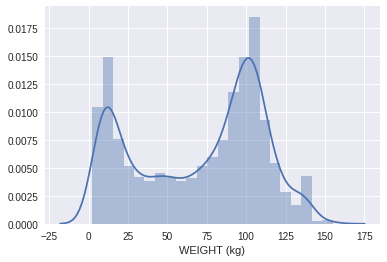

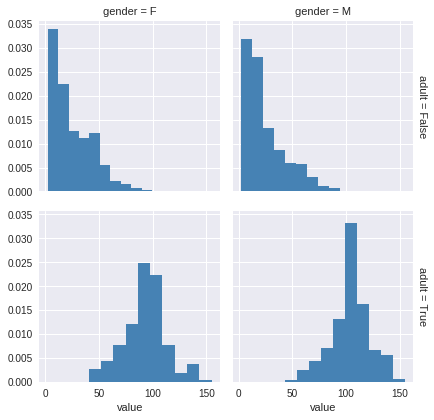

In [0]:
w = obs[obs['obs_code']=='29463-7']
print('Number of patients: {:,}'.format(len(w)))
weights = w['obs_value'].astype(np.float)
mean = np.mean(weights)
print('Avg weight: ',mean)
sns.distplot(weights)
plt.xlabel("WEIGHT (kg)")
plt.show()

weight_obs = pd.DataFrame()
weight_obs['gender'] = obs['gender']
weight_obs['value'] = weights
weight_obs['adult'] = obs['adult']
sns.set(style="darkgrid")
g = sns.FacetGrid(weight_obs, row= 'adult', col='gender', margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, 'value', color="steelblue", lw=0, normed=True)



## 3.3 Save the Dataframes


Write all of the dataframes to disk for the next step

In [0]:
### 3.1 Save the Dataframes


obs.to_pickle(datadir+'/temp/obs.tmp')

# 4.0 Feature Selection

In [0]:
from sklearn.ensemble import RandomForestClassifier

#obs = pd.read_pickle(datadir+'/temp/obs.tmp')

overdose_patient_deaths = list(obs[(obs['obs_code'] == '69453-9') & (obs['obs_value'].str.contains('overdose'))]['enc_pat_id'])
overdose_patients = set(obs[obs['enc_reason_code']=='55680006']['enc_pat_id'])

print(len(overdose_patients))

overdose_obs = obs[obs.obs_pat_id.isin(overdose_patients)]
print(overdose_obs.shape)
display(overdose_obs.head(10))

obs['overdose'] = (obs['enc_pat_id'].isin(overdose_patients))
display(obs[obs['overdose']].head(10))




57
(6044, 34)


,obs_date,obs_pat_id,obs_enc_id,obs_code,obs_description,obs_value,obs_units,birth_date,death_date,ssn,...,age_at_visit,adult,enc_id,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description,overdose
2749,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,0811833c-cd36-4b88-aca3-3f736c7e5ab9,8302-2,Body Height,156.3,cm,1991-11-21,NaT,999-54-7189,...,17.0,False,0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2750,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,0811833c-cd36-4b88-aca3-3f736c7e5ab9,29463-7,Body Weight,58.7,kg,1991-11-21,NaT,999-54-7189,...,17.0,False,0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2751,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,0811833c-cd36-4b88-aca3-3f736c7e5ab9,39156-5,Body Mass Index,24.0,kg/m2,1991-11-21,NaT,999-54-7189,...,17.0,False,0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2752,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,0811833c-cd36-4b88-aca3-3f736c7e5ab9,8462-4,Diastolic Blood Pressure,87.8,mmHg,1991-11-21,NaT,999-54-7189,...,17.0,False,0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2753,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,0811833c-cd36-4b88-aca3-3f736c7e5ab9,8480-6,Systolic Blood Pressure,111.6,mmHg,1991-11-21,NaT,999-54-7189,...,17.0,False,0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2754,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,8302-2,Body Height,156.5,cm,1991-11-21,NaT,999-54-7189,...,18.0,True,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2755,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,29463-7,Body Weight,59.8,kg,1991-11-21,NaT,999-54-7189,...,18.0,True,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2756,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,39156-5,Body Mass Index,24.4,kg/m2,1991-11-21,NaT,999-54-7189,...,18.0,True,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2757,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,8462-4,Diastolic Blood Pressure,84.0,mmHg,1991-11-21,NaT,999-54-7189,...,18.0,True,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2758,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,8480-6,Systolic Blood Pressure,105.5,mmHg,1991-11-21,NaT,999-54-7189,...,18.0,True,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True


,obs_date,obs_pat_id,obs_enc_id,obs_code,obs_description,obs_value,obs_units,birth_date,death_date,ssn,...,age_at_visit,adult,enc_id,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description,overdose
2749,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,0811833c-cd36-4b88-aca3-3f736c7e5ab9,8302-2,Body Height,156.3,cm,1991-11-21,NaT,999-54-7189,...,17.0,False,0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2750,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,0811833c-cd36-4b88-aca3-3f736c7e5ab9,29463-7,Body Weight,58.7,kg,1991-11-21,NaT,999-54-7189,...,17.0,False,0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2751,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,0811833c-cd36-4b88-aca3-3f736c7e5ab9,39156-5,Body Mass Index,24.0,kg/m2,1991-11-21,NaT,999-54-7189,...,17.0,False,0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2752,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,0811833c-cd36-4b88-aca3-3f736c7e5ab9,8462-4,Diastolic Blood Pressure,87.8,mmHg,1991-11-21,NaT,999-54-7189,...,17.0,False,0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2753,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,0811833c-cd36-4b88-aca3-3f736c7e5ab9,8480-6,Systolic Blood Pressure,111.6,mmHg,1991-11-21,NaT,999-54-7189,...,17.0,False,0811833c-cd36-4b88-aca3-3f736c7e5ab9,2009-04-09,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2754,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,8302-2,Body Height,156.5,cm,1991-11-21,NaT,999-54-7189,...,18.0,True,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2755,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,29463-7,Body Weight,59.8,kg,1991-11-21,NaT,999-54-7189,...,18.0,True,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2756,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,39156-5,Body Mass Index,24.4,kg/m2,1991-11-21,NaT,999-54-7189,...,18.0,True,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2757,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,8462-4,Diastolic Blood Pressure,84.0,mmHg,1991-11-21,NaT,999-54-7189,...,18.0,True,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True
2758,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,8480-6,Systolic Blood Pressure,105.5,mmHg,1991-11-21,NaT,999-54-7189,...,18.0,True,54f1168a-8d09-412c-9fd9-8c79ff7ebacb,2010-04-15,31a691da-0aba-48a8-8966-c91c62d7650a,185349003,Encounter for check up (procedure),NaN,NaN,True


In [0]:
# fit an Extra Trees model to the data


noncat_col_names = ['age_at_visit']
cat_col_names = ['obs_code', 'marital', 'race', 'ethnicity', 'gender', 'adult', 'overdose']
pred_col_names = ['obs_code', 'marital', 'race', 'ethnicity', 'gender', 'adult', 'age_at_visit']

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
d = defaultdict(LabelEncoder)
df = obs[cat_col_names]

# Encoding the variable
fit = df.apply(lambda x: d[x.name].fit_transform(x.astype(str)))
display(fit.head(20))
print(d)

# Inverse the encoded
#fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
#df.apply(lambda x: d[x.name].transform(x))

df2 = pd.concat([fit, obs[noncat_col_names]],axis=1)
display(df2.head(5))



,obs_code,marital,race,ethnicity,gender,adult,overdose
0,48,2,5,10,0,0,0
1,10,2,5,10,0,0,0
2,48,2,5,10,0,0,0
3,10,2,5,10,0,0,0
4,50,2,5,10,0,0,0
5,51,2,5,10,0,0,0
6,48,2,5,10,0,0,0
7,10,2,5,10,0,0,0
8,16,2,5,10,0,0,0
9,50,2,5,10,0,0,0


defaultdict(<class 'sklearn.preprocessing.label.LabelEncoder'>, {'obs_code': LabelEncoder(), 'marital': LabelEncoder(), 'race': LabelEncoder(), 'ethnicity': LabelEncoder(), 'gender': LabelEncoder(), 'adult': LabelEncoder(), 'overdose': LabelEncoder()})


,obs_code,marital,race,ethnicity,gender,adult,overdose,age_at_visit
0,48,2,5,10,0,0,0,0.0
1,10,2,5,10,0,0,0,0.0
2,48,2,5,10,0,0,0,0.0
3,10,2,5,10,0,0,0,0.0
4,50,2,5,10,0,0,0,0.0


In [0]:
missing_data = df2[df2.isnull().any(axis=1)]
print("Shape = ",missing_data.shape)
display(missing_data.head(10))

good_data = df2[df2.notnull().any(axis=1)]
print("Shape = ",good_data.shape)
display(good_data.head(10))
print(good_data.dtypes)

#good_data['age_at_visit'] = good_data['age_at_visit'].astype('int64')

good_data = good_data[good_data['age_at_visit'].notnull()]
print("Shape = ",good_data.shape)
print(np.isfinite(good_data).all())



Shape =  (15471, 8)


,obs_code,marital,race,ethnicity,gender,adult,overdose,age_at_visit
112695,52,2,3,15,2,2,0,NaN
112696,52,2,3,15,2,2,0,NaN
112697,52,2,3,15,2,2,0,NaN
112698,52,2,3,15,2,2,0,NaN
112699,52,2,3,15,2,2,0,NaN
112700,52,2,3,15,2,2,0,NaN
112701,52,2,3,15,2,2,0,NaN
112702,52,2,3,15,2,2,0,NaN
112703,52,2,3,15,2,2,0,NaN
112704,52,2,3,15,2,2,0,NaN


Shape =  (128166, 8)


,obs_code,marital,race,ethnicity,gender,adult,overdose,age_at_visit
0,48,2,5,10,0,0,0,0.0
1,10,2,5,10,0,0,0,0.0
2,48,2,5,10,0,0,0,0.0
3,10,2,5,10,0,0,0,0.0
4,50,2,5,10,0,0,0,0.0
5,51,2,5,10,0,0,0,0.0
6,48,2,5,10,0,0,0,4.0
7,10,2,5,10,0,0,0,4.0
8,16,2,5,10,0,0,0,4.0
9,50,2,5,10,0,0,0,4.0


obs_code          int64
marital           int64
race              int64
ethnicity         int64
gender            int64
adult             int64
overdose          int64
age_at_visit    float64
dtype: object
Shape =  (112695, 8)
obs_code        True
marital         True
race            True
ethnicity       True
gender          True
adult           True
overdose        True
age_at_visit    True
dtype: bool


## 4.2.2 Display the relative importance of each variable

In [0]:
model = RandomForestClassifier()
model.fit(good_data[pred_col_names], good_data['overdose'])
# display the relative importance of each attribute
print(model.feature_importances_)

# Number of Male vs Female overdoses
display(pd.crosstab(obs['race'],obs['overdose'],margins=True))
pd.crosstab(obs['race'],obs['overdose'],normalize='index')



[0.08706078 0.03227855 0.04776765 0.3565577  0.05321289 0.04417297
 0.37894947]


overdose,False,True,All
race,,,
asian,5287,308,5595
black,7834,214,8048
hispanic,1706,365,2071
native,1315,0,1315
white,90509,5157,95666
All,106651,6044,112695


overdose,False,True
race,,
asian,0.944951,0.055049
black,0.973410,0.026590
hispanic,0.823757,0.176243
native,1.000000,0.000000
white,0.946094,0.053906


### 4.2.3 Display Correlations between all the variables

In [0]:
display(good_data.corr())


,obs_code,marital,race,ethnicity,gender,adult,overdose,age_at_visit
obs_code,1.000000,0.299148,-0.029262,0.021643,0.014271,-0.315239,-0.027354,-0.307529
marital,0.299148,1.000000,-0.018524,-0.014900,0.030186,-0.848567,-0.104258,-0.756286
race,-0.029262,-0.018524,1.000000,0.090462,-0.008628,0.050789,0.003707,0.070001
ethnicity,0.021643,-0.014900,0.090462,1.000000,0.145405,-0.039018,-0.014918,-0.015990
gender,0.014271,0.030186,-0.008628,0.145405,1.000000,-0.011710,-0.083966,-0.029115
adult,-0.315239,-0.848567,0.050789,-0.039018,-0.011710,1.000000,0.091512,0.818747
overdose,-0.027354,-0.104258,0.003707,-0.014918,-0.083966,0.091512,1.000000,0.015348
age_at_visit,-0.307529,-0.756286,0.070001,-0.015990,-0.029115,0.818747,0.015348,1.000000


,age_at_visit,overdose
age_at_visit,1.000000,0.015348
overdose,0.015348,1.000000


In [0]:
# Get Opioid code list from VSAC
# oid 1.3.6.1.4.1.6997.4.1.2.234.999.3.2
xl = pd.ExcelFile(datadir + '/AllPrescribableOpioidsUsedForPainControlIncludingInactiveMedications.xlsx')
df = xl.parse("Code List", skiprows=12)
display(df.head(10))
opioids_rxnorm = list(df['Code'].astype(np.str))
#opioids_rxnorm.extend(['1049369','1310197','1049544'])
print(opioids_rxnorm)



,Code,Description,Code System,Code System Version,Code System OID,TTY
0,1010600,Buprenorphine 2 MG / Naloxone 0.5 MG Oral Strip,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
1,1010603,Buprenorphine 2 MG / Naloxone 0.5 MG Oral Stri...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
2,1010604,Buprenorphine 8 MG / Naloxone 2 MG Oral Strip,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
3,1010606,Buprenorphine 8 MG / Naloxone 2 MG Oral Strip ...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
4,1010608,Buprenorphine 2 MG / Naloxone 0.5 MG Sublingua...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
5,1010609,Buprenorphine 8 MG / Naloxone 2 MG Sublingual ...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
6,1014599,Acetaminophen 300 MG / Oxycodone Hydrochloride...,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
7,1014615,Acetaminophen 300 MG / Oxycodone Hydrochloride...,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
8,1014632,Acetaminophen 300 MG / Oxycodone Hydrochloride...,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
9,102492,Heroin 0.6 MG/ML Oral Solution,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD


['1010600', '1010603', '1010604', '1010606', '1010608', '1010609', '1014599', '1014615', '1014632', '102492', '1037259', '1044427', '1049214', '1049216', '1049221', '1049223', '1049225', '1049227', '1049233', '1049251', '1049260', '1049267', '1049270', '1049502', '1049504', '1049543', '1049545', '1049557', '1049563', '1049565', '1049574', '1049576', '1049580', '1049582', '1049584', '1049586', '1049589', '1049593', '1049595', '1049599', '1049601', '1049604', '1049611', '1049613', '1049615', '1049618', '1049620', '1049621', '1049623', '1049625', '1049635', '1049637', '1049640', '1049642', '1049647', '1049650', '1049651', '1049655', '1049658', '1049683', '1049686', '1049691', '1049696', '1049717', '1049719', '1049720', '1049721', '1049727', '1050409', '1050490', '1053647', '1053651', '1053652', '1053654', '1053655', '1053657', '1053658', '1053660', '1053661', '1053663', '1053664', '1053666', '106500', '106505', '1086310', '1113313', '1113314', '1113316', '1115573', '1115575', '1115577', '

In [0]:
#dt = {'PATIENT':np.str, 'ENCOUNTER':np.str, 'CODE':np.str, 
#      'DESCRIPTION':np.str, 'REASONCODE':np.str, 'REASONDESCRIPTION':np.str }
#medications = pd.read_csv(datadir + '/medications.csv', header=0, parse_dates = [0,1], dtype=dt, keep_default_na=False)
#medications['CODE'] = medications.CODE.astype(np.str)
#print(medications['CODE'][0])
print(medications.dtypes)
display(medications.head(5))

#display(medications[medications['CODE'].isin(opioids_rxnorm)].head(10))
print(medications[medications['med_code'].isin(opioids_rxnorm)].shape)
#display(medications[medications['CODE']==1049221].head(10))
display(medications[medications['med_code']=='1049544'].head(10))



med_start_date            datetime64[ns]
med_stop_date                     object
med_pat_id                        object
med_enc_id                        object
med_code                          object
med_description                   object
med_reason_code                   object
med_reason_description            object
dtype: object


,med_start_date,med_stop_date,med_pat_id,med_enc_id,med_code,med_description,med_reason_code,med_reason_description
0,2012-11-24,2012-12-01,03e552de-c720-42af-9995-79649f3f05e4,35a91c99-2537-4174-a628-cc15339b5447,608680,Acetaminophen 160 MG,10509002,Acute bronchitis (disorder)
1,2011-04-17,2011-07-16,827002da-feb8-4848-9ef8-a203f5c50f83,3f58d9b6-045f-4e60-9d5f-7d8531817998,282464,Acetaminophen 160 MG Oral Tablet,NaN,NaN
2,2015-11-07,2015-11-21,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,2bc6a99b-1406-49ad-b2fb-ab5aff28f2b0,392151,Amoxicillin 200 MG Oral Tablet,NaN,NaN
3,2015-11-07,2015-11-21,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,2bc6a99b-1406-49ad-b2fb-ab5aff28f2b0,198405,Ibuprofen 100 MG Oral Tablet,NaN,NaN
4,2016-03-20,2016-04-03,a5bf8162-2080-41b2-a30b-1fdbc1e8a283,90d945dd-deea-4842-8e3a-ce2daeafdf37,392151,Amoxicillin 200 MG Oral Tablet,NaN,NaN


(136, 8)


,med_start_date,med_stop_date,med_pat_id,med_enc_id,med_code,med_description,med_reason_code,med_reason_description
97,2013-01-05,2013-03-09,f3345c23-beb9-43ce-9750-efd35042130f,dee4dad4-d021-4099-953a-64074b57da69,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
136,2010-07-13,2010-08-31,4c90bcda-1058-40fa-82e2-bc267f8c53be,f06d05a1-f06f-4dc7-acc8-bc3d1454b41c,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
143,2011-03-07,2011-03-28,c5bf2250-39d6-4f4e-8ab9-1a984a47b961,84b77282-715b-4e55-8535-b0a07673fad5,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
185,2012-08-05,2012-09-09,77e3b48a-c935-4129-90bb-c04f4d3c3d25,6b528793-485f-4868-b3c3-afa6222cd0bc,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
265,2013-11-28,2013-12-05,f8c6d677-bda1-4729-8840-b43b5a5cd764,c41bc4e6-3405-4e8d-83c3-efd60876c322,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
346,2012-04-20,2012-05-11,9c0f6613-d68e-461c-bf7b-76bbb61ff1ef,82f1a0c8-5e93-4c0d-96a9-f419bddf9394,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
543,2012-12-04,2013-01-08,e531aece-5d2e-4b65-b741-eb6f1af33059,336dc040-2cc6-4629-8505-9b81b3db2416,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
717,2011-10-09,2011-12-18,8d5c01e2-96f4-4c3b-9478-d13e132cacf7,2aaba8f9-ce93-4a6a-8b44-677bb6b14cc8,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
887,2013-07-12,2013-08-30,c5b38c5f-1d78-4a85-b2a6-c5b5a5d374fd,923c2e61-45b5-46a2-8692-7c0ecebc0940,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN
1042,2017-07-04,2017-08-22,3d796a59-50a9-40d6-a023-172e6b442498,0cb0a91a-9714-4553-b662-5d92162dc1fb,1049544,oxyCODONE Hydrochloride 15 MG [OxyCONTIN],NaN,NaN


In [0]:
patients_prescribed_opioids = set(medications[medications['med_code'].isin(opioids_rxnorm)]['med_pat_id'])
print(len(patients_prescribed_opioids))

d2 = set(patients_prescribed_opioids).intersection(overdose_patients)
print(len(d2))
print(d2)



125
12
{'3eaed230-1c60-4221-a96c-f6af5d871072', '214b72b0-dfaf-49d9-ac74-ad0ea8601467', '83bdc4a5-9fda-4c4d-a5fb-db3a8b80d703', '9e2279db-9fa0-42d6-aaab-565a166d2e16', '1e89a7f8-9e83-426f-a0c4-2bc75d6803bb', 'c9eaf966-9849-44f6-b4fc-8e99f53bc877', 'e722cfed-e393-4fc3-b746-ba8b4c7c5d49', '31a691da-0aba-48a8-8966-c91c62d7650a', 'ecc0b301-7d99-4ea3-8e92-3f8d97cef66f', '2ffe444b-ca8f-40e5-b1aa-65d9c666a682', 'a8eaaf7e-95b0-43ea-b784-670ffa51443c', '639d614e-83ee-4939-8ff0-76287b23d839'}


In [0]:
meds_prescribed_to_overdose_patients = medications[medications['med_pat_id'].isin(overdose_patients)]
display(meds_prescribed_to_overdose_patients.head(10))




,med_start_date,med_stop_date,med_pat_id,med_enc_id,med_code,med_description,med_reason_code,med_reason_description
145,2008-11-01,2009-10-27,31a691da-0aba-48a8-8966-c91c62d7650a,cc03ef5b-2837-4d66-b194-58f5163b3ea6,1000128,1 ML Depo-Provera 150 MG/ML Injection,NaN,NaN
146,2010-05-30,2010-06-27,31a691da-0aba-48a8-8966-c91c62d7650a,315c228c-ae1c-4260-98ad-b843af0718d4,1310197,Acetaminophen 300 MG / HYDROcodone Bitartrate ...,NaN,NaN
147,2010-10-22,2011-05-12,31a691da-0aba-48a8-8966-c91c62d7650a,5e532248-7160-42ec-938a-04c643096dd3,748962,Camila 28 Day Pack,NaN,NaN
149,2015-01-17,2015-01-31,31a691da-0aba-48a8-8966-c91c62d7650a,0c9a84a8-32de-40b8-87cc-ebcab2ed0e34,310965,Ibuprofen 200 MG Oral Tablet,NaN,NaN
154,2011-11-09,2012-11-03,41f2410e-1e70-4ac3-b99c-110653753bf9,f40a2f16-395e-4b7a-8237-ccfa25dda064,757594,Jolivette 28 Day Pack,NaN,NaN
155,2012-11-03,2013-10-29,41f2410e-1e70-4ac3-b99c-110653753bf9,fdf95f01-9655-4f23-a214-bbfd8f4b599e,748962,Camila 28 Day Pack,NaN,NaN
156,2016-03-26,2017-03-21,41f2410e-1e70-4ac3-b99c-110653753bf9,aba3e7f8-7a73-452b-a9a7-075568f74813,748962,Camila 28 Day Pack,NaN,NaN
157,2018-02-19,2018-03-05,41f2410e-1e70-4ac3-b99c-110653753bf9,ae30db6b-4d4e-4f7c-a471-1eb0e50b2e7b,1020137,Dextromethorphan Hydrobromide 1 MG/ML,10509002,Acute bronchitis (disorder)
158,2018-03-20,NaN,41f2410e-1e70-4ac3-b99c-110653753bf9,62527f63-76e2-4241-a1f9-b3104d9682a3,1111011,Nexplanon 68 MG Drug Implant,NaN,NaN
441,2013-10-16,2014-10-11,24bd8d72-ee56-4a64-b142-b28c8b1b4b17,d4568f29-43bc-4bd1-b360-2b3d7a138343,1367439,NuvaRing 0.12/0.015 MG per 24HR 21 Day Vaginal...,NaN,NaN


In [0]:
pt_id = '3eaed230-1c60-4221-a96c-f6af5d871072'
#pt = patients.query('pat_id == @pt_id')
#pt = patients[patients.pat_id == pt_id].iloc[0]
pt = patients.loc[pt_id]

print('PATIENT: {} {} ({} {} {} {})'.format(pt['first'],pt['last'],pt['marital'],pt['race'],pt['gender'],pt['ethnicity']))
encs = encounters[encounters.enc_pat_id == pt_id]
#print(encs.shape)
for i, e in encs.iterrows():
    print('  {}: {} ({}) ({})'.format(e['enc_date'], e['enc_description'], e['enc_code'], e['enc_reason_description']))
    meds = medications[medications['med_enc_id'] == e.name]
    for j, m in meds.iterrows():
        print('     MED: {} to {}: {} ({})'.format(m['med_start_date'], m['med_stop_date'], m['med_description'], m['med_code']))
    labs = observations[observations['obs_enc_id'] == e.name]
    for k, l in labs.iterrows():
        print('     LAB: {:%Y-%m-%d %H:%M}: {} ({}) {} {}'.format(l['obs_date'], l['obs_description'], l['obs_code'], l['obs_value'], l['obs_units']))

PATIENT: Queenie922 Stokes453 (M white F english)
  2008-06-15 00:00:00: Prenatal initial visit (424441002) (Normal pregnancy)
  2008-07-13 00:00:00: Prenatal visit (424619006) (Normal pregnancy)
  2008-08-10 00:00:00: Prenatal visit (424619006) (Normal pregnancy)
  2008-09-07 00:00:00: Prenatal visit (424619006) (Normal pregnancy)
  2008-10-05 00:00:00: Prenatal visit (424619006) (Normal pregnancy)
  2008-11-02 00:00:00: Prenatal visit (424619006) (Normal pregnancy)
  2008-11-30 00:00:00: Prenatal visit (424619006) (Normal pregnancy)
  2009-12-28 00:00:00: Prenatal visit (424619006) (Normal pregnancy)
  2009-01-11 00:00:00: Prenatal visit (424619006) (Normal pregnancy)
  2009-01-18 00:00:00: Obstetric emergency hospital admission (183460006) (Normal pregnancy)
  2009-03-01 00:00:00: Postnatal visit (169762003) (nan)
  2010-02-09 00:00:00: Emergency room admission (50849002) (nan)
     MED: 2010-02-09 00:00:00 to 2010-03-02: Acetaminophen 325 MG Oral Tablet (313782)
  2010-05-30 00:00: